# 👋 Hello, ODSC East 2022!

Let's talk about Graph Data Science and Neo4j. We'll be adapting some materials from Zach Blumenfeld's [blog series](https://neo4j.com/developer-blog/exploring-fraud-detection-neo4j-graph-data-science-part-1/) about exploring Fraud Detection approaches using graphs.

Thing's we're going to touch upon:

1. 🧑‍🔬 Using **Neo4j Graph Data Science** from the comfort of your existing notebook environment.
2. 🧪 The basics of running graph algorithms.
3. 🌻 How to visualize and explore a graph with **Neo4j Bloom**.

----

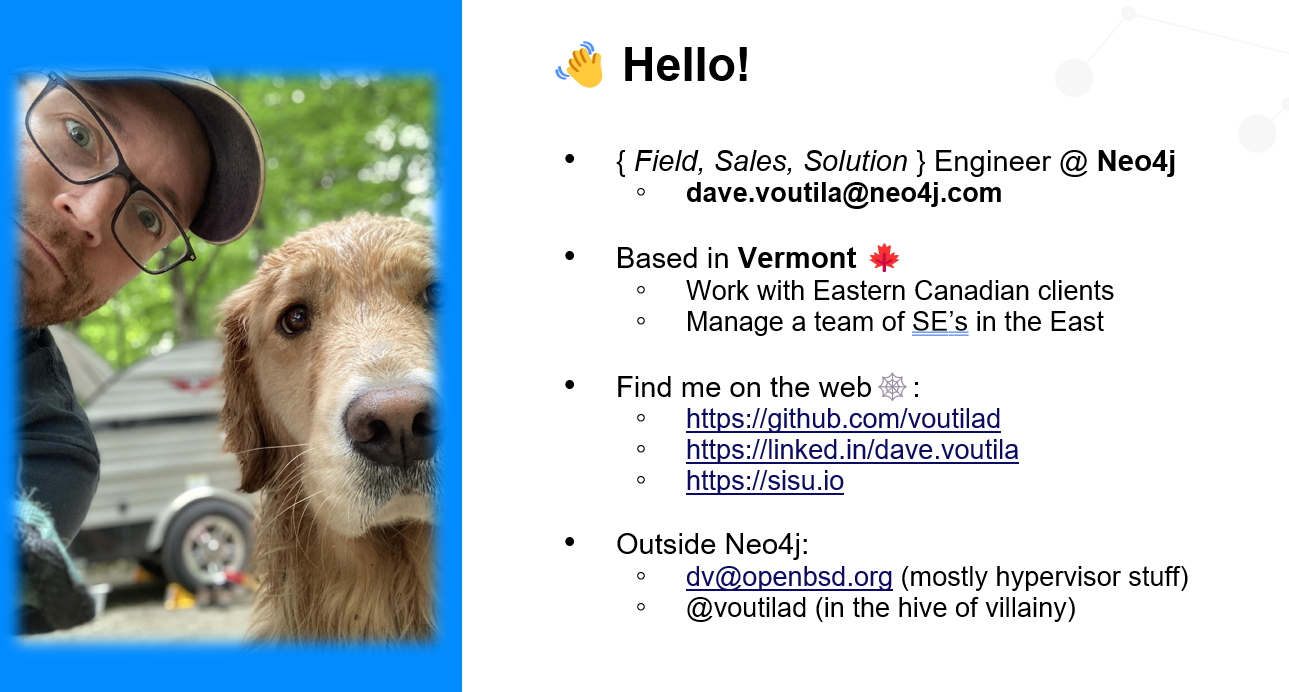

---

In [1]:
!pip install graphdatascience pandas seaborn

  Using cached graphdatascience-1.0.0-py3-none-any.whl (34 kB)
  Using cached neo4j-4.4.2-py3-none-any.whl


In [2]:
import pandas as pd
import seaborn as sns

from graphdatascience import GraphDataScience

from itertools import chain, tee
from threading import Thread
from time import asctime

sns.set_theme()

def batch_df(df: pd.DataFrame, batch_size: int):
    """
    A generator of batches of 'rows' in a given DataFrame.
    """
    rows, _ = df.shape
    a, b = tee(chain(range(0, rows, batch_size), [rows]))
    next(b, None)
    for i, j in zip(a, b):
        yield df.iloc[i:j].to_dict(orient='records') # pandas DataFrame support is still experimental

## 1. Building the Graph
Before we can do fun graphy things, we need a graph!

### Our Data Model
First let's take a look at what we're modeling.

![](./data-model.svg)

### Our Dataset
For the sake of time, let's assume someone was kind enough to dump some tables from our warehouse into Apache Parquet files and staged them in ☁️ Google Cloud Storage.

In [3]:
!gsutil ls gs://neo4j_voutila/fraud-demo

gs://neo4j_voutila/fraud-demo/
gs://neo4j_voutila/fraud-demo/card.parquet
gs://neo4j_voutila/fraud-demo/device.parquet
gs://neo4j_voutila/fraud-demo/has_cc.parquet
gs://neo4j_voutila/fraud-demo/has_ip.parquet
gs://neo4j_voutila/fraud-demo/ip.parquet
gs://neo4j_voutila/fraud-demo/p2p.parquet
gs://neo4j_voutila/fraud-demo/referred.parquet
gs://neo4j_voutila/fraud-demo/used.parquet
gs://neo4j_voutila/fraud-demo/user.parquet


In [4]:
dataset = {
    "nodes": ["Card", "Device", "IP", "User"],
    "edges": ["HAS_CC", "HAS_IP", "P2P", "REFERRED", "USED"],
}

> An aside: Pandas makes it easy to load Parquet into DataFrames

In [5]:
card = pd.read_parquet('gs://neo4j_voutila/fraud-demo/card.parquet')
print(f'loaded {card.size:,} card')
card

loaded 356,454 card


,guid,cardType,level
0,ffa2872c-07ff-4aa0-8f76-b7e320194d48,CARD_TYPE_13,LEVEL_TYPE_104
1,e2e11709-7dec-4623-be34-d0a38213f2e5,CARD_TYPE_19,LEVEL_TYPE_85
2,b495e5dd-d7f8-4d0b-9fad-1c343a90b84f,CARD_TYPE_19,LEVEL_TYPE_102
3,2a5c9df6-0a10-454c-9f8a-6f57573afee2,CARD_TYPE_5,LEVEL_TYPE_81
4,70ca8b2e-0b86-4e70-a1b8-35b90aa15443,CARD_TYPE_6,LEVEL_TYPE_176
...,...,...,...
118813,3b9cc43b-f260-42c8-840d-b86ca29bc6d1,CARD_TYPE_13,LEVEL_TYPE_132
118814,2b68cf66-eefe-44d1-98a5-62db9e06f832,CARD_TYPE_13,LEVEL_TYPE_39
118815,42972e1f-6404-4061-a7f5-647406dfa1f0,CARD_TYPE_6,LEVEL_TYPE_181
118816,11204447-580b-4d83-b5fc-3efdf7861df5,CARD_TYPE_19,LEVEL_TYPE_123


### Connecting to Neo4j's AuraDS
Accessing Neo4j using the newly released [Graph Data Science Client](https://github.com/neo4j/graph-data-science-client) for Python 🐍 is super simple. We just need:

- connection string to our database
- a username
- a password

In this case, I'm lazy...but not lazy enough to put my password into this notebook! So we'll just load my password from a local file on this notebook server.

In [6]:
AURADS_URI = 'neo4j+s://1322be1b.databases.neo4j.io'
NEO4J_USER = 'neo4j'
NEO4J_PASS = 'set-me'

# just a simple way to keep our password out of the notebook 😉
with open('creds.txt', mode='r') as f:
    NEO4J_PASS = f.readlines()[0]

Now let's connect a GDS client to the database and check we've got all the plumbing sorted out!

In [7]:
# Create our client and check connectivity
gds = GraphDataScience(AURADS_URI, auth=(NEO4J_USER, NEO4J_PASS), aura_ds=True)
gds.list()

,name,description,signature,type
0,gds.allShortestPaths.delta.mutate,The Delta Stepping shortest path algorithm com...,gds.allShortestPaths.delta.mutate(graphName ::...,procedure
1,gds.allShortestPaths.delta.mutate.estimate,Returns an estimation of the memory consumptio...,gds.allShortestPaths.delta.mutate.estimate(gra...,procedure
2,gds.allShortestPaths.delta.stream,The Delta Stepping shortest path algorithm com...,gds.allShortestPaths.delta.stream(graphName ::...,procedure
3,gds.allShortestPaths.delta.stream.estimate,Returns an estimation of the memory consumptio...,gds.allShortestPaths.delta.stream.estimate(gra...,procedure
4,gds.allShortestPaths.delta.write,The Delta Stepping shortest path algorithm com...,gds.allShortestPaths.delta.write(graphName :: ...,procedure
...,...,...,...,...
290,gds.util.infinity,RETURN gds.util.infinity() - Return infinity a...,gds.util.infinity() :: (FLOAT?),function
291,gds.util.isFinite,RETURN gds.util.isFinite(value) - Return true ...,gds.util.isFinite(value :: NUMBER?) :: (BOOLEAN?),function
292,gds.util.isInfinite,RETURN gds.util.isInfinite(value) - Return tru...,gds.util.isInfinite(value :: NUMBER?) :: (BOOL...,function
293,gds.util.nodeProperty,Returns a node property value from a named in-...,"gds.util.nodeProperty(graphName :: STRING?, no...",function


### Preparing the Data Load
While you can just dump data into Neo4j, it's usually best to tell any database a bit about your intentions. Let's use our `dataset` map and define some unique Label/property indexes. This gives some schema to our graph before we even load any data.

In [8]:
cypher = "CREATE INDEX IF NOT EXISTS FOR (n:{label}) ON (n.guid)"
for node in dataset["nodes"]:
    gds.run_cypher(cypher.format(label=node))
    
gds.run_cypher("SHOW INDEXES")

,id,name,state,populationPercent,uniqueness,type,entityType,labelsOrTypes,properties,indexProvider
0,15,index_10757d6a,ONLINE,100.0,NONUNIQUE,BTREE,NODE,[User],[flaggedDegree],native-btree-1.0
1,3,index_107cda47,ONLINE,100.0,NONUNIQUE,BTREE,NODE,[Card],[guid],native-btree-1.0
2,6,index_1f8e8d25,ONLINE,100.0,NONUNIQUE,BTREE,NODE,[User],[guid],native-btree-1.0
3,7,index_2e1200dd,ONLINE,100.0,NONUNIQUE,BTREE,NODE,[IP],[guid],native-btree-1.0
4,1,index_343aff4e,ONLINE,100.0,NONUNIQUE,LOOKUP,NODE,None,None,token-lookup-1.0
5,12,index_8214646e,ONLINE,100.0,NONUNIQUE,BTREE,NODE,[IP],[degree],native-btree-1.0
6,14,index_893a97e5,ONLINE,100.0,NONUNIQUE,BTREE,NODE,[User],[degree],native-btree-1.0
7,13,index_90dbaeb4,ONLINE,100.0,NONUNIQUE,BTREE,NODE,[IP],[flaggedDegree],native-btree-1.0
8,11,index_b43c4711,ONLINE,100.0,NONUNIQUE,BTREE,NODE,[Device],[flaggedDegree],native-btree-1.0
9,17,index_c9159f8e,ONLINE,100.0,NONUNIQUE,BTREE,NODE,[FraudRiskUser],[wccId],native-btree-1.0


### Load the Data!
We'll be using the best practice of batching our data as we load it. In the interest of time (again: I'm lazy 🦥), we'll multithread this process.

> If you're not familiar with Python's `threading` module or writing concurrent code, in general, don't sweat it 😅. You can feel free to ask me afterwards!

In [9]:
# Load our nodes!
##########################################################
cypher_template = """
    UNWIND $batches AS batch
    MERGE (n:{label} {{guid: batch.guid}}) SET n += batch
    RETURN count(*) AS cnt
"""

def load_nodes(cypher: str, batch: dict, output: list = []):
    result = gds.run_cypher(cypher, params={"batches": batch})
    output.append(result["cnt"][0])

node_cnt = 0
print(f"Starting to load nodes @ {asctime()}")

for node in dataset["nodes"]:
    # read in our DataFrame
    df = pd.read_parquet(f"gs://neo4j_voutila/fraud-demo/{node.lower()}.parquet")
    print(f"Read {df.shape[0]:,} {node} nodes...")
    
    # populate our cypher template
    cypher = cypher_template.format(label=node)
    print(f"Using cypher:{cypher}")
          
    # best practice is to load nodes in batches
    workers, output = [], []
    for batch in batch_df(df, batch_size=25_000):
        t = Thread(target=load_nodes, daemon=True, args=(cypher, batch, output))
        t.start()
        workers.append(t)
    [t.join() for t in workers]
    print(f"Loaded {sum(output):,} {node}s\n")
    node_cnt += sum(output)

print(f"-----------------------------------\nDone loading {node_cnt:,} nodes @ {asctime()}!")

Starting to load nodes @ Wed Apr 20 13:35:04 2022
Read 118,818 Card nodes...
Using cypher:
    UNWIND $batches AS batch
    MERGE (n:Card {guid: batch.guid}) SET n += batch
    RETURN count(*) AS cnt

Loaded 118,818 Cards

Read 51,451 Device nodes...
Using cypher:
    UNWIND $batches AS batch
    MERGE (n:Device {guid: batch.guid}) SET n += batch
    RETURN count(*) AS cnt

Loaded 51,451 Devices

Read 585,855 IP nodes...
Using cypher:
    UNWIND $batches AS batch
    MERGE (n:IP {guid: batch.guid}) SET n += batch
    RETURN count(*) AS cnt

Loaded 585,855 IPs

Read 33,732 User nodes...
Using cypher:
    UNWIND $batches AS batch
    MERGE (n:User {guid: batch.guid}) SET n += batch
    RETURN count(*) AS cnt

Loaded 33,732 Users

-----------------------------------
Done loading 789,856 nodes @ Wed Apr 20 13:35:19 2022!


We'll kick off our edges next. While that runs, let's take a look at **Bloom** 🌻.

In [10]:
# Load our edges!
#########################################################
cypher_template = """
    UNWIND $batches AS batch
    MATCH (a:{start_label} {{guid: batch.start_guid}})
    MATCH (b:{end_label} {{guid: batch.end_guid}})
    MERGE (a)-[r:{edge_type}]->(b) SET r += batch
    RETURN count(r) AS cnt
"""

def load_edges(cypher: str, batch: list, output: list = []):
    if "transactionDateTime" in batch[0]:
        [d.update({"transactionDateTime": d["transactionDateTime"].to_pydatetime()}) for d in batch]
    result = gds.run_cypher(cypher, params={"batches": batch})
    output.append(result["cnt"][0])

edge_cnt = 0
print(f"Starting to load nodes @ {asctime()}")

for edge in dataset["edges"]:
    # read in our edge DataFrame
    df = pd.read_parquet(f"gs://neo4j_voutila/fraud-demo/{edge.lower()}.parquet")
    print(f"Read {df.shape[0]:,} {edge} edges...")
    
    # we need to massage some data...
    if "transactionDateTime" in df.columns:
        df["transactionDateTime"] = df["transactionDateTime"].map(lambda ts: ts.to_pydatetime())
    
    # our edges are simple: only a type exists between only a single pair of node labels and
    # our labels are wellformed in our source files (🍀 lucky me!)
    node_labels = df["start_label"][0], df["end_label"][0]
    cypher = cypher_template.format(edge_type=edge.upper(), 
                                    start_label=node_labels[0], 
                                    end_label=node_labels[1])
    print(f"Loading using cypher:{cypher}")
    
    # best practice is to load edges serially or with retries (if done concurrently)
    output = []
    for batch in batch_df(df, batch_size=40_000):
        load_edges(cypher, batch, output)
    print(f"Loaded {sum(output):,} {node}s\n")
    edge_cnt += sum(output)

print(f"-----------------------------------\nDone loading {edge_cnt:,} edges @ {asctime()}!")

Starting to load nodes @ Wed Apr 20 13:35:19 2022
Read 128,066 HAS_CC edges...
Loading using cypher:
    UNWIND $batches AS batch
    MATCH (a:User {guid: batch.start_guid})
    MATCH (b:Card {guid: batch.end_guid})
    MERGE (a)-[r:HAS_CC]->(b) SET r += batch
    RETURN count(r) AS cnt

Loaded 128,066 Users

Read 1,488,949 HAS_IP edges...
Loading using cypher:
    UNWIND $batches AS batch
    MATCH (a:User {guid: batch.start_guid})
    MATCH (b:IP {guid: batch.end_guid})
    MERGE (a)-[r:HAS_IP]->(b) SET r += batch
    RETURN count(r) AS cnt

Loaded 1,488,949 Users

Read 102,832 P2P edges...
Loading using cypher:
    UNWIND $batches AS batch
    MATCH (a:User {guid: batch.start_guid})
    MATCH (b:User {guid: batch.end_guid})
    MERGE (a)-[r:P2P]->(b) SET r += batch
    RETURN count(r) AS cnt

Loaded 102,832 Users

Read 1,870 REFERRED edges...
Loading using cypher:
    UNWIND $batches AS batch
    MATCH (a:User {guid: batch.start_guid})
    MATCH (b:User {guid: batch.end_guid})
    M

---

## 2. Analyzing our Graph
Ok, we've got a graph...now what? 🤔

Let's take a look at a few approaches for analyzing our data, specifically demonstrating:

- Defining graph _projections_ (in memory representations of the graph)
- Calling graph algorithms like _PageRank_ or _Louvain_
- Putting together an ML pipeline directly in Neo4j

### First some Housekeeping 🏠
Before we begin...just cleanup🧹 any previous mess someone may have made.

In [11]:
for g in gds.graph.list()["graphName"]:
    print(f"dropping graph: {g}")
    gds.graph.drop(gds.graph.get(g))

dropping graph: flagged-users
dropping graph: wcc
dropping graph: regular-users


### Find At Risk Communities
Let's say we want to find and flag users of the service that are at risk of fraud.

If a `User` has a connection to a user we know is committing fraud or the victim of fraud, let's assume that `User` is at risk.

Consequently, an at risk `User` exposes all members of their community to risk.

Here's what we'll do:

1. We already have some reported fraudulent transfers, to flag the `User`s we know are at risk in hindsight
2. 

In [12]:
reversed = { "orientation": "REVERSE" } # just a shortcut to save some typing

# Let's flag our Users
gds.run_cypher("""
    MATCH (u:User) WHERE u.fraudMoneyTransfer = 1
    SET u:FlaggedUser
""")

# We'll look at flagged and unflagged separately...
regular_users, _ = gds.graph.project("regular-users", dataset["nodes"],
                                     { "HAS_CC": reversed, "HAS_IP": reversed, "USED": reversed })
flagged_users, _ = gds.graph.project("flagged-users", dataset["nodes"],
                                     { "HAS_CC": reversed, "HAS_IP": reversed, "USED": reversed })

# Run the algo and write back
gds.degree.write(regular_users, writeProperty="degree")
gds.degree.write(flagged_users, writeProperty="flaggedDegree")

for label in dataset["nodes"]:
    gds.run_cypher(f"CREATE INDEX IF NOT EXISTS FOR (c:{label}) on (c.degree)")
    gds.run_cypher(f"CREATE INDEX IF NOT EXISTS FOR (c:{label}) on (c.flaggedDegree)")

# Let's analyze 
gds.run_cypher("""
    MATCH (n) WHERE n:Card OR n:Device OR n:IP
    SET n.flaggedRatio = toFloat(n.flaggedDegree) / toFloat(n.degree)
""")

gds.run_cypher("""
MATCH (n:Card) WHERE n.degree > 1
    WITH toFloat(count(n)) AS total
    MATCH (n:Card) WHERE n.degree > 1
    WITH n, total, CASE
        WHEN n.flaggedRatio=0 THEN '0'
        WHEN n.flaggedRatio=1  THEN '1'
        ELSE 'Between 0-1' END AS flaggedUserRatio
    RETURN flaggedUserRatio, count(n) AS count,
        round(toFloat(count(n))/total,3) AS percentCount
    ORDER BY flaggedUserRatio
""")

,flaggedUserRatio,count,percentCount
0,1,8490,1.0


#### Let's build our Communities

We'll use _Weakly Connected Components_ to find ways to partition our network into distinct communities based on `User` relationships.

In this example, we'll incorporate *two* different connections between `User`s:

1. Peer-to-peer interaction with a shared Credit Card
2. Shared identifier (device, IP, card)

In [13]:
gds.run_cypher("""
    // Find occurrences of direct p2p communication
    MATCH (u1:User)-[r:P2P]->(u2)
    WITH u1, u2, count(r) AS cnt
    
    // Look for shared CCs between them
    MATCH (u1)-[:HAS_CC]->(n)<-[:HAS_CC]-(u2)
    WITH u1, u2, count(DISTINCT n) AS cnt
    
    MERGE (u1)-[s:P2P_WITH_SHARED_CARD]->(u2)
    RETURN count(DISTINCT s) AS num_p2p_with_shared_card
""")

,num_p2p_with_shared_card
0,6240


In [14]:
gds.run_cypher("""
    MATCH (u1:User)-[:HAS_CC|USED]->(n)<-[:HAS_CC|USED]-(u2)
    WHERE n.degree <= 10 AND id(u1) < id(u2)
    WITH u1, u2, count(DISTINCT n) as cnt
    
    MATCH (u1)-[:HAS_CC|USED|HAS_IP]->(m)<-[:HAS_CC|USED|HAS_IP]-(u2)
    WITH u1, u2, count(DISTINCT m) as cnt
    WHERE cnt > 2
    
    MERGE (u1)-[s:SHARED_IDS]->(u2)
    RETURN count(DISTINCT s) AS num_shared_ids
""")

,num_shared_ids
0,5316


In [15]:
# Now we project our monopartite graphs into memory as one bigger graph
wcc, _ = gds.graph.project('wcc', ['User'], {
    'SHARED_IDS': {'orientation': 'UNDIRECTED'},
    'P2P_WITH_SHARED_CARD': {'orientation': 'UNDIRECTED'}
})

# Run WCC
result = gds.wcc.write(wcc, writeProperty='wccId')
wcc.drop()

# And prepare to analyze the results
gds.run_cypher("CREATE INDEX IF NOT EXISTS FOR (u:User) ON (u.wccId)")
gds.run_cypher("CREATE INDEX IF NOT EXISTS FOR (u:FraudRiskUser) ON (u.wccId)")

result

writeMillis                                                            297
nodePropertiesWritten                                                33732
componentCount                                                       28203
componentDistribution    {'p99': 3, 'min': 1, 'max': 175, 'mean': 1.196...
postProcessingMillis                                                     6
preProcessingMillis                                                      0
computeMillis                                                           22
configuration            {'writeConcurrency': 4, 'seedProperty': None, ...
Name: 0, dtype: object

What do our communities look like?

<AxesSubplot:xlabel='community_size', ylabel='Count'>

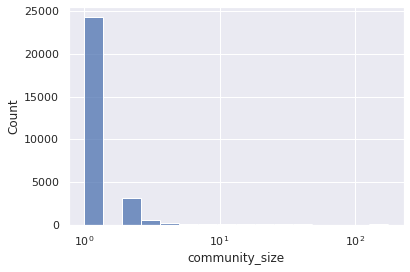

In [16]:
df = gds.run_cypher("""
    MATCH (u:User)
    WITH u.wccId AS wcc, count(*) AS community_size
    WHERE community_size < 1000
    RETURN *
""")
sns.histplot(data=df["community_size"], log_scale=True)

That's quite the long tail! Let's tag them and visualize in [Bloom](https://bloom.neo4j.io/index.html?connectURL=neo4j%2Bs%3A//1322be1b.databases.neo4j.io)...

In [17]:
gds.run_cypher("""
    MATCH (u:User)
    WITH u.wccId AS wcc, count(*) AS community_size 
    WHERE 10 < community_size < 1000
    
    MATCH (u:User {wccId:wcc})
    SET u:Interesting
    RETURN count(*) AS num_tagged
""")

,num_tagged
0,430


---

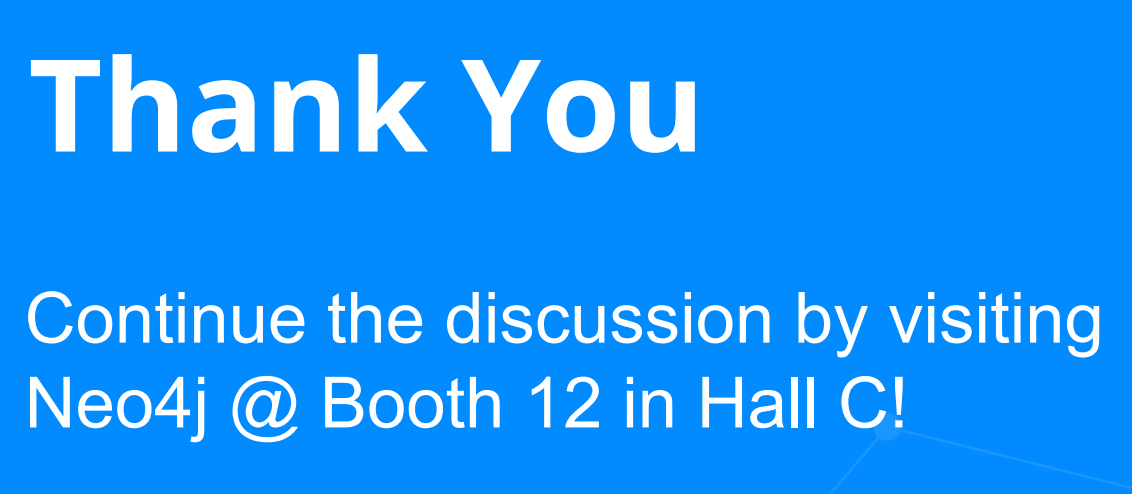